In [2]:
from google.colab import files
uploaded = files.upload()


Saving defect-predictor-starter.zip to defect-predictor-starter.zip


In [3]:
!unzip defect-predictor-starter.zip -d defect-predictor
%cd defect-predictor

Archive:  defect-predictor-starter.zip
  inflating: defect-predictor/defect-predictor/requirements.txt  
  inflating: defect-predictor/defect-predictor/README.md  
  inflating: defect-predictor/defect-predictor/src/__init__.py  
  inflating: defect-predictor/defect-predictor/src/extract/static_metrics.py  
  inflating: defect-predictor/defect-predictor/src/extract/process_metrics.py  
  inflating: defect-predictor/defect-predictor/src/extract/__init__.py  
  inflating: defect-predictor/defect-predictor/src/label/labeler.py  
  inflating: defect-predictor/defect-predictor/src/label/__init__.py  
  inflating: defect-predictor/defect-predictor/src/models/train.py  
  inflating: defect-predictor/defect-predictor/src/models/predict.py  
  inflating: defect-predictor/defect-predictor/src/models/__init__.py  
  inflating: defect-predictor/defect-predictor/src/report/make_report.py  
  inflating: defect-predictor/defect-predictor/src/report/app.py  
  inflating: defect-predictor/defect-predict

In [4]:
!ls

defect-predictor


In [5]:
%cd /content/defect-predictor/defect-predictor

/content/defect-predictor/defect-predictor


In [6]:
!pip install -r requirements.txt
!python -c "import pandas, sklearn, flask; print('✅ Environment OK')"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 kB 6.6 MB/s eta 0:00:00
✅ Environment OK


In [7]:
!git clone https://github.com/psf/requests.git target_repo

Cloning into 'target_repo'...
remote: Enumerating objects: 26288, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 26288 (delta 6), reused 1 (delta 1), pack-reused 26276 (from 2)
Receiving objects: 100% (26288/26288), 12.97 MiB | 22.59 MiB/s, done.
Resolving deltas: 100% (17238/17238), done.


In [8]:
!mkdir -p data

In [9]:
!python -m src.extract.static_metrics --repo ./target_repo --out data/static.csv

[static_metrics] Wrote: data/static.csv (36 files)


In [10]:
!mkdir -p data
!ls data

static.csv


In [11]:
!python -m src.label.labeler --repo ./target_repo --out data/labels.csv

[labeler] Wrote: data/labels.csv (86 flagged files)


In [12]:
!head -n 10 data/labels.csv

file,defect_prone
requests/packages/urllib3/util/timeout.py,1
requests/packages/urllib3/contrib/pyopenssl.py,1
tests/conftest.py,1
requests/packages/urllib3/util/response.py,1
docs/conf.py,1
requests/packages/chardet/codingstatemachine.py,1
requests/safe_mode.py,1
requests/core.py,1
requests/packages/urllib3/util.py,1


In [13]:
# patch src/extract/process_metrics.py to use added_lines/deleted_lines
from pathlib import Path

code = r"""
import argparse
import pandas as pd
from pydriller import Repository
from datetime import datetime

def mine(repo_path: str) -> pd.DataFrame:
    rows = {}
    for commit in Repository(repo_path).traverse_commits():
        for m in commit.modified_files:
            fpath = m.new_path or m.old_path
            if not fpath or not fpath.endswith(".py"):
                continue
            r = rows.get(fpath, dict(file=fpath, commits=0, added=0, removed=0, authors=set(), last_ts=None))
            r["commits"] += 1
            # PyDriller fields:
            added = getattr(m, "added_lines", 0) or 0
            deleted = getattr(m, "deleted_lines", 0) or 0
            r["added"] += added
            r["removed"] += deleted
            author_sig = f"{(commit.author.name or '')}<{(commit.author.email or '')}>"
            r["authors"].add(author_sig)
            r["last_ts"] = commit.author_date
            rows[fpath] = r

    out = []
    for v in rows.values():
        out.append({
            "file": v["file"],
            "commits": v["commits"],
            "churn": v["added"] + v["removed"],
            "authors": len(v["authors"]),
            "last_ts": v["last_ts"].isoformat() if isinstance(v["last_ts"], datetime) else None
        })
    return pd.DataFrame(out)

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--repo", required=True, help="Path to a local git repository")
    ap.add_argument("--out", required=True, help="Output CSV path")
    args = ap.parse_args()

    df = mine(args.repo)
    df.to_csv(args.out, index=False)
    print(f"[process_metrics] Wrote: {args.out} ({len(df)} rows)")

if __name__ == "__main__":
    main()
"""
Path("src/extract/process_metrics.py").write_text(code, encoding="utf-8")
print("✅ Patched src/extract/process_metrics.py")


✅ Patched src/extract/process_metrics.py


In [14]:
# ensure data folder exists
!mkdir -p data

# static metrics (you already ran this, safe to run again)
!python -m src.extract.static_metrics --repo ./target_repo --out data/static.csv
!head -n 5 data/static.csv

# process metrics (now with the fix)
!python -m src.extract.process_metrics --repo ./target_repo --out data/process.csv
!head -n 5 data/process.csv

# labels (you have them, re-run is fine)
!python -m src.label.labeler --repo ./target_repo --out data/labels.csv
!head -n 5 data/labels.csv


[static_metrics] Wrote: data/static.csv (36 files)
file,loc,avg_cc,mi,pep8
target_repo/setup.py,,,,
target_repo/docs/conf.py,,,,
target_repo/tests/test_utils.py,,,,
target_repo/tests/__init__.py,,,,
[process_metrics] Wrote: data/process.csv (287 rows)
file,commits,churn,authors,last_ts
setup.py,169,1052,47,2025-07-25T13:42:15-07:00
test_requests.py,366,6490,106,2016-03-03T20:09:13+01:00
requests/__init__.py,179,1080,30,2023-05-03T08:39:44-07:00
requests/core.py,132,3793,9,2011-10-19T16:47:46-04:00
[labeler] Wrote: data/labels.csv (86 flagged files)
file,defect_prone
requests/config.py,1
requests/certs.py,1
tests/test_lowlevel.py,1
tests/test_testserver.py,1


In [15]:
!mkdir -p artifacts
!python -m src.models.train --features data/static.csv data/process.csv --labels data/labels.csv --out artifacts
!cat artifacts/metrics.csv

[train] Saved models & metrics to artifacts
model,ROC_AUC,PR_AUC,F1
logreg,0.9399509803921569,0.91525507172566,0.8
rf,0.9479166666666667,0.9065548924883964,0.8387096774193549


In [16]:
!mkdir -p reports

In [17]:
!python -m src.models.predict --model artifacts/rf.pkl \
  --features data/static.csv data/process.csv --out reports/risk.csv

[predict] Wrote: reports/risk.csv


In [ ]:
from google.colab import files
files.download("data/static.csv")
files.download("data/process.csv")
files.download("data/labels.csv")
files.download("reports/risk.csv")  # predicted results

In [35]:
import pandas as pd
static = pd.read_csv("data/static.csv")
print("Static Metrics Shape:", static.shape)
static.head(20).style.background_gradient(cmap="Blues")

Static Metrics Shape: (36, 5)


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,file,loc,avg_cc,mi,pep8
0,target_repo/setup.py,nan,nan,nan,nan
1,target_repo/docs/conf.py,nan,nan,nan,nan
2,target_repo/tests/test_utils.py,nan,nan,nan,nan
3,target_repo/tests/__init__.py,nan,nan,nan,nan
4,target_repo/tests/test_adapters.py,nan,nan,nan,nan
5,target_repo/tests/conftest.py,nan,nan,nan,nan
6,target_repo/tests/test_requests.py,nan,nan,nan,nan
7,target_repo/tests/test_structures.py,nan,nan,nan,nan
8,target_repo/tests/utils.py,nan,nan,nan,nan
9,target_repo/tests/test_packages.py,nan,nan,nan,nan


In [36]:
process = pd.read_csv("data/process.csv")
print("Process Metrics Shape:", process.shape)
process.head(20).style.background_gradient(cmap="Greens")

Process Metrics Shape: (287, 5)


,file,commits,churn,authors,last_ts
0,setup.py,169,1052,47,2025-07-25T13:42:15-07:00
1,test_requests.py,366,6490,106,2016-03-03T20:09:13+01:00
2,requests/__init__.py,179,1080,30,2023-05-03T08:39:44-07:00
3,requests/core.py,132,3793,9,2011-10-19T16:47:46-04:00
4,docs/conf.py,39,784,15,2025-05-31T11:59:51-05:00
5,requests/packages/__init__.py,19,332,8,2017-05-27T10:49:57-04:00
6,requests/packages/poster/__init__.py,6,110,1,2011-11-09T22:44:58-08:00
7,requests/packages/poster/encode.py,3,1242,1,2011-11-09T22:44:58-08:00
8,requests/packages/poster/streaminghttp.py,4,607,2,2011-11-09T22:44:58-08:00
9,requests/async.py,35,586,11,2012-11-26T17:27:35-08:00


In [37]:
labels = pd.read_csv("data/labels.csv")
print("Labels Shape:", labels.shape)
labels.head(20).style.background_gradient(cmap="Oranges")

Labels Shape: (86, 2)


,file,defect_prone
0,requests/config.py,1
1,requests/certs.py,1
2,tests/test_lowlevel.py,1
3,tests/test_testserver.py,1
4,src/requests/utils.py,1
5,tests/test_packages.py,1
6,requests/defaults.py,1
7,test_requests_ext.py,1
8,tests/test_cookies.py,1
9,requests/hooks.py,1


In [39]:
# --- Import Required Library ---
import pandas as pd
from google.colab import files

# --- Load Datasets ---
static = pd.read_csv("data/static.csv")
process = pd.read_csv("data/process.csv")
labels = pd.read_csv("data/labels.csv")

print("Datasets Loaded Successfully:")
print(f"Static: {static.shape} | Process: {process.shape} | Labels: {labels.shape}")

# --- Merge All into One DataFrame ---
df = static.merge(process, on="file", how="outer") \
           .merge(labels, on="file", how="left") \
           .fillna(0)

print("\n✅ Merged Dataset Created:")
print(f"Final Shape: {df.shape}")

# --- Preview First 20 Rows with Colored Styling ---
df_preview = df.head(50).style.background_gradient(cmap="Purples")
display(df_preview)

# --- Save and Download Merged Dataset ---
output_path = "data/merged_dataset.csv"
df.to_csv(output_path, index=False)
print(f"\n📁 Merged dataset saved as: {output_path}")

# Download to your computer
#files.download(output_path)


Datasets Loaded Successfully:
Static: (36, 5) | Process: (287, 5) | Labels: (86, 2)

✅ Merged Dataset Created:
Final Shape: (323, 10)


,file,loc,avg_cc,mi,pep8,commits,churn,authors,last_ts,defect_prone
0,backup.py,0.000000,0.000000,0.000000,0.000000,4.000000,1208.000000,1.000000,2012-12-17T09:57:13-05:00,0.000000
1,docs/_themes/flask_theme_support.py,0.000000,0.000000,0.000000,0.000000,1.000000,86.000000,1.000000,2011-05-15T00:38:59-04:00,0.000000
2,docs/api.py,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,2011-05-15T21:01:44-04:00,0.000000
3,docs/conf.py,0.000000,0.000000,0.000000,0.000000,39.000000,784.000000,15.000000,2025-05-31T11:59:51-05:00,1.000000
4,dummyserver/__init__.py,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2015-11-24T23:08:38+01:00,0.000000
5,dummyserver/server.py,0.000000,0.000000,0.000000,0.000000,2.000000,43.000000,1.000000,2015-11-25T13:52:53+01:00,0.000000
6,invokefile.py,0.000000,0.000000,0.000000,0.000000,2.000000,10.000000,1.000000,2013-07-06T14:04:50+10:00,0.000000
7,requests/__about__.py,0.000000,0.000000,0.000000,0.000000,2.000000,16.000000,2.000000,2017-05-25T20:07:38-04:00,0.000000
8,requests/__init__.py,0.000000,0.000000,0.000000,0.000000,179.000000,1080.000000,30.000000,2023-05-03T08:39:44-07:00,1.000000
9,requests/__version__.py,0.000000,0.000000,0.000000,0.000000,44.000000,214.000000,6.000000,2023-05-22T08:10:32-07:00,1.000000



📁 Merged dataset saved as: data/merged_dataset.csv


In [18]:
!head -n 15 reports/risk.csv

file,loc,avg_cc,mi,pep8,commits,churn,authors,last_ts,risk
requests/cookies.py,,,,,80.0,1382.0,33.0,2023-07-29T22:50:43-03:00,1.0
tests/test_utils.py,,,,,66.0,2451.0,34.0,2025-06-05T16:55:33+02:00,1.0
requests/sessions.py,,,,,335.0,4277.0,110.0,2023-08-12T12:03:10-07:00,1.0
requests/utils.py,,,,,271.0,4041.0,107.0,2023-08-12T12:03:10-07:00,1.0
requests/adapters.py,,,,,152.0,1965.0,54.0,2023-08-12T12:03:10-07:00,1.0
requests/api.py,,,,,141.0,1342.0,60.0,2023-06-26T18:09:23+01:00,1.0
requests/async.py,,,,,35.0,586.0,11.0,2012-11-26T17:27:35-08:00,1.0
requests/auth.py,,,,,118.0,2004.0,50.0,2023-08-12T12:03:10-07:00,1.0
requests/packages/urllib3/response.py,,,,,43.0,2113.0,13.0,2017-05-27T10:49:57-04:00,0.9966666666666667
requests/packages/urllib3/poolmanager.py,,,,,40.0,1474.0,12.0,2017-05-27T10:49:57-04:00,0.9966666666666667
tests/test_lowlevel.py,,,,,24.0,728.0,13.0,2022-04-29T13:16:58-06:00,0.9966666666666667
requests/__version__.py,,,,,44.0,214.0,6.0,2023-05-22T08:10:32-07:00,0.996666

In [19]:
!python -m src.report.make_report --risk reports/risk.csv --out reports/report.html

[make_report] Wrote: reports/report.html


In [20]:
!cat artifacts/metrics.csv

model,ROC_AUC,PR_AUC,F1
logreg,0.9399509803921569,0.91525507172566,0.8
rf,0.9479166666666667,0.9065548924883964,0.8387096774193549


In [21]:
!head -n 15 reports/risk.csv

file,loc,avg_cc,mi,pep8,commits,churn,authors,last_ts,risk
requests/cookies.py,,,,,80.0,1382.0,33.0,2023-07-29T22:50:43-03:00,1.0
tests/test_utils.py,,,,,66.0,2451.0,34.0,2025-06-05T16:55:33+02:00,1.0
requests/sessions.py,,,,,335.0,4277.0,110.0,2023-08-12T12:03:10-07:00,1.0
requests/utils.py,,,,,271.0,4041.0,107.0,2023-08-12T12:03:10-07:00,1.0
requests/adapters.py,,,,,152.0,1965.0,54.0,2023-08-12T12:03:10-07:00,1.0
requests/api.py,,,,,141.0,1342.0,60.0,2023-06-26T18:09:23+01:00,1.0
requests/async.py,,,,,35.0,586.0,11.0,2012-11-26T17:27:35-08:00,1.0
requests/auth.py,,,,,118.0,2004.0,50.0,2023-08-12T12:03:10-07:00,1.0
requests/packages/urllib3/response.py,,,,,43.0,2113.0,13.0,2017-05-27T10:49:57-04:00,0.9966666666666667
requests/packages/urllib3/poolmanager.py,,,,,40.0,1474.0,12.0,2017-05-27T10:49:57-04:00,0.9966666666666667
tests/test_lowlevel.py,,,,,24.0,728.0,13.0,2022-04-29T13:16:58-06:00,0.9966666666666667
requests/__version__.py,,,,,44.0,214.0,6.0,2023-05-22T08:10:32-07:00,0.996666

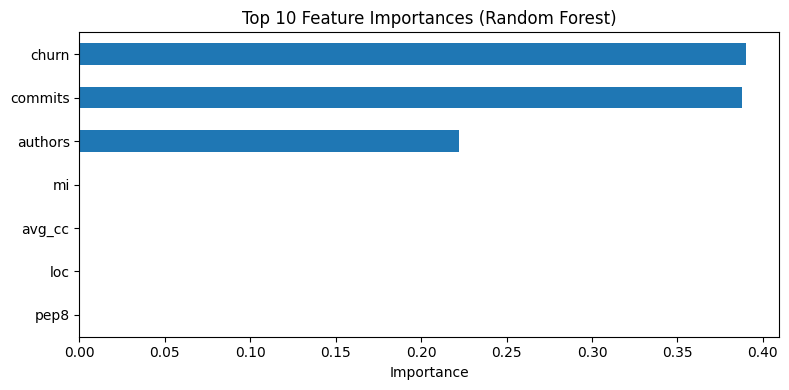

,0
churn,0.390048
commits,0.387693
authors,0.222259
mi,0.000000
avg_cc,0.000000
loc,0.000000
pep8,0.000000


In [24]:
import joblib, pandas as pd, matplotlib.pyplot as plt

# Load model and features
rf = joblib.load("artifacts/rf.pkl")

df_static = pd.read_csv("data/static.csv")
df_process = pd.read_csv("data/process.csv")

# Merge and clean
df = df_static.merge(df_process, on="file", how="outer").fillna(0)
X = df.drop(columns=["file","last_ts"], errors="ignore")

# Calculate importances
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(8,4))
feat_imp.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

feat_imp.head(10)


In [28]:
!python -m src.report.app

 * Serving Flask app 'app'
 * Debug mode: on
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (inotify)
 * Debugger is active!
 * Debugger PIN: 613-135-968


In [33]:
# Preview inside Colab
from IPython.display import HTML
HTML(filename='reports/report.html')

# Or download it to your computer
#from google.colab import files
#files.download('reports/report.html')


file,loc,avg_cc,mi,pep8,commits,churn,authors,last_ts,risk
requests/sessions.py,NaN,NaN,NaN,NaN,335.0,4277.0,110.0,2023-08-12T12:03:10-07:00,1.000000
tests/test_utils.py,NaN,NaN,NaN,NaN,66.0,2451.0,34.0,2025-06-05T16:55:33+02:00,1.000000
requests/cookies.py,NaN,NaN,NaN,NaN,80.0,1382.0,33.0,2023-07-29T22:50:43-03:00,1.000000
requests/auth.py,NaN,NaN,NaN,NaN,118.0,2004.0,50.0,2023-08-12T12:03:10-07:00,1.000000
requests/async.py,NaN,NaN,NaN,NaN,35.0,586.0,11.0,2012-11-26T17:27:35-08:00,1.000000
requests/api.py,NaN,NaN,NaN,NaN,141.0,1342.0,60.0,2023-06-26T18:09:23+01:00,1.000000
requests/adapters.py,NaN,NaN,NaN,NaN,152.0,1965.0,54.0,2023-08-12T12:03:10-07:00,1.000000
requests/utils.py,NaN,NaN,NaN,NaN,271.0,4041.0,107.0,2023-08-12T12:03:10-07:00,1.000000
requests/__version__.py,NaN,NaN,NaN,NaN,44.0,214.0,6.0,2023-05-22T08:10:32-07:00,0.996667
requests/help.py,NaN,NaN,NaN,NaN,13.0,171.0,7.0,2022-04-29T13:16:58-06:00,0.996667
